Author: Jingcheng Shi 

Visualize the morphology of the dendritic branches and synapses assignment on it

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib
from Bio import Phylo
from Bio.Phylo.PhyloXML import Phylogeny, Clade

In [3]:
# 递归遍历分支并编号
def assign_branch_numbers(clade, branch_list, count=0):
    """
    给树的每个分支编号，并记录在 branch_list 中。
    """
    branch_list.append((count, clade))
    count += 1
    for child in clade.clades:
        count = assign_branch_numbers(child, branch_list, count)
    return count

# 递归移除不需要的分支
def prune_tree(clade):
    clade.clades = [child for child in clade.clades if child in branches_to_keep]
    for child in clade.clades:
        prune_tree(child)


## Test Code

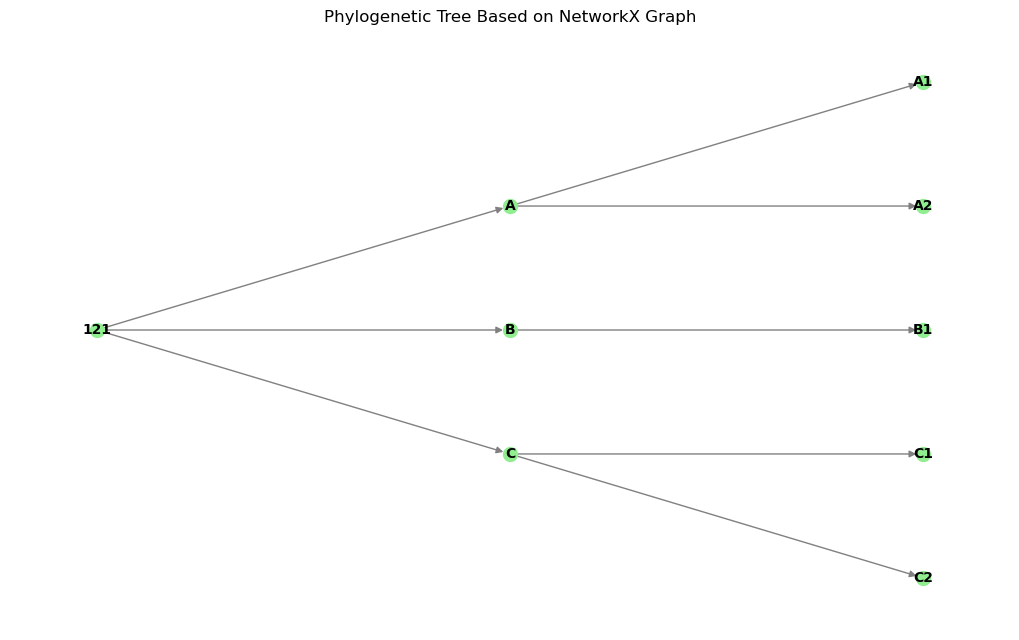

In [1]:
# Step 1: Construct a sample graph
G = nx.DiGraph()

# Define edges based on hypothetical phylogenetic data
edges = [
    (121, "A"), (121, "B"), (121, "C"),
    ("A", "A1"), ("A", "A2"), ("B", "B1"), ("C", "C1"), ("C", "C2")
]
G.add_edges_from(edges)

# Step 2: Assign a subset level to each node
# Root node (121) is at level 0, its children at level 1, and their children at level 2
for node in G.nodes():
    if node == 121:
        G.nodes[node]['subset'] = 0
    elif node in ["A", "B", "C"]:
        G.nodes[node]['subset'] = 1
    else:
        G.nodes[node]['subset'] = 2

# Step 3: Set node positions in a multipartite layout
pos = nx.multipartite_layout(G, subset_key="subset")

# Step 4: Draw the phylogenetic tree
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color="lightgreen", edge_color="grey", node_size=100, font_size=10, font_weight="bold")
plt.title("Phylogenetic Tree Based on NetworkX Graph")

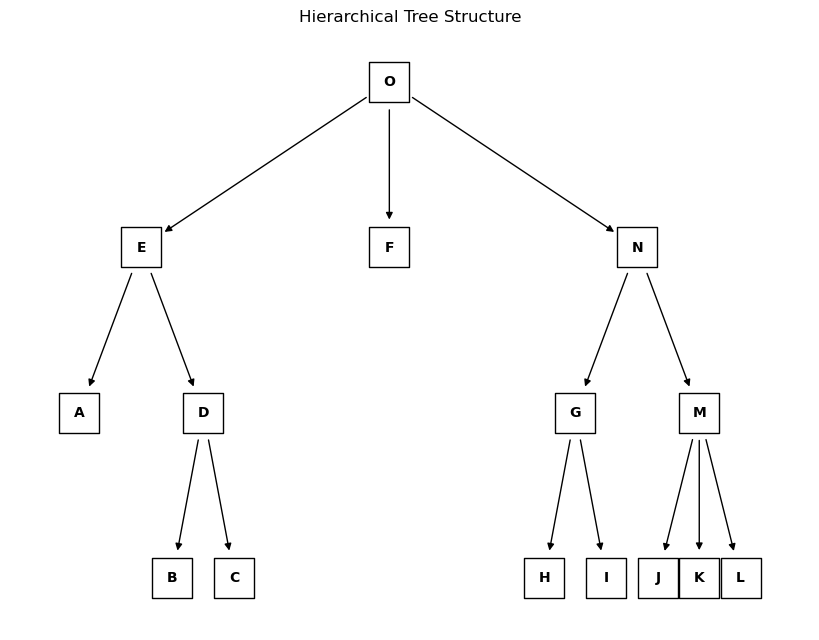

In [21]:
# Step 1: Define the tree structure as edges
edges = [
    ('O', 'E'), ('O', 'F'), ('O', 'N'),
    ('E', 'A'), ('E', 'D'), ('D', 'B'), ('D', 'C'),
    ('N', 'G'), ('N', 'M'), 
    ('G', 'H'), ('G', 'I'), ('M', 'J'), ('M', 'K'), ('M', 'L')
]

# Step 2: Create a directed graph and add edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Step 3: Define the layout using a custom hierarchy positioning function
def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph):
        raise TypeError("The graph is not directed")
    if not nx.is_tree(G):
        raise TypeError("The graph is not a tree")
    if children:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    return pos

# Step 4: Generate positions for nodes in a hierarchical layout
pos = hierarchy_pos(G, root='O')

# Step 5: Draw the tree
plt.figure(figsize=(8, 6))
nx.draw(G, pos=pos, with_labels=True, node_size=800, node_shape='s', node_color="white", edgecolors="black", font_size=10, font_weight="bold")
plt.title("Hierarchical Tree Structure")

In [46]:
# Create a simple hierarchical graph (tree structure) with weights
G = nx.DiGraph()
G.add_weighted_edges_from([
    ('Root', 'A', 1.0), ('Root', 'B', 2.0),
    ('A', 'A1', 1), ('A', 'A2', 2),
    ('B', 'B1', 1), ('B', 'B2', 2)
])

def nx_to_clade(graph, node):
    """Recursively convert NetworkX nodes to Bio.Phylo Clade nodes."""
    clade = Clade(name=node)
    for child in graph.successors(node):  # Only directed edges from parent to child
        edge_data = graph.get_edge_data(node, child)
        weight = edge_data['weight'] if edge_data else 1.0
        child_clade = nx_to_clade(graph, child)
        child_clade.branch_length = weight
        clade.clades.append(child_clade)
    return clade

# Convert the NetworkX graph to a PhyloXML tree
root = 'Root'  # Define the root of your NetworkX graph
root_clade = nx_to_clade(G, root)
phylo_tree = Phylogeny.from_clade(root_clade, rooted=True)

# Save the PhyloXML tree to an XML file
with open("tree.xml", "w") as xml_file:
    Phylo.write([phylo_tree], xml_file, "phyloxml")

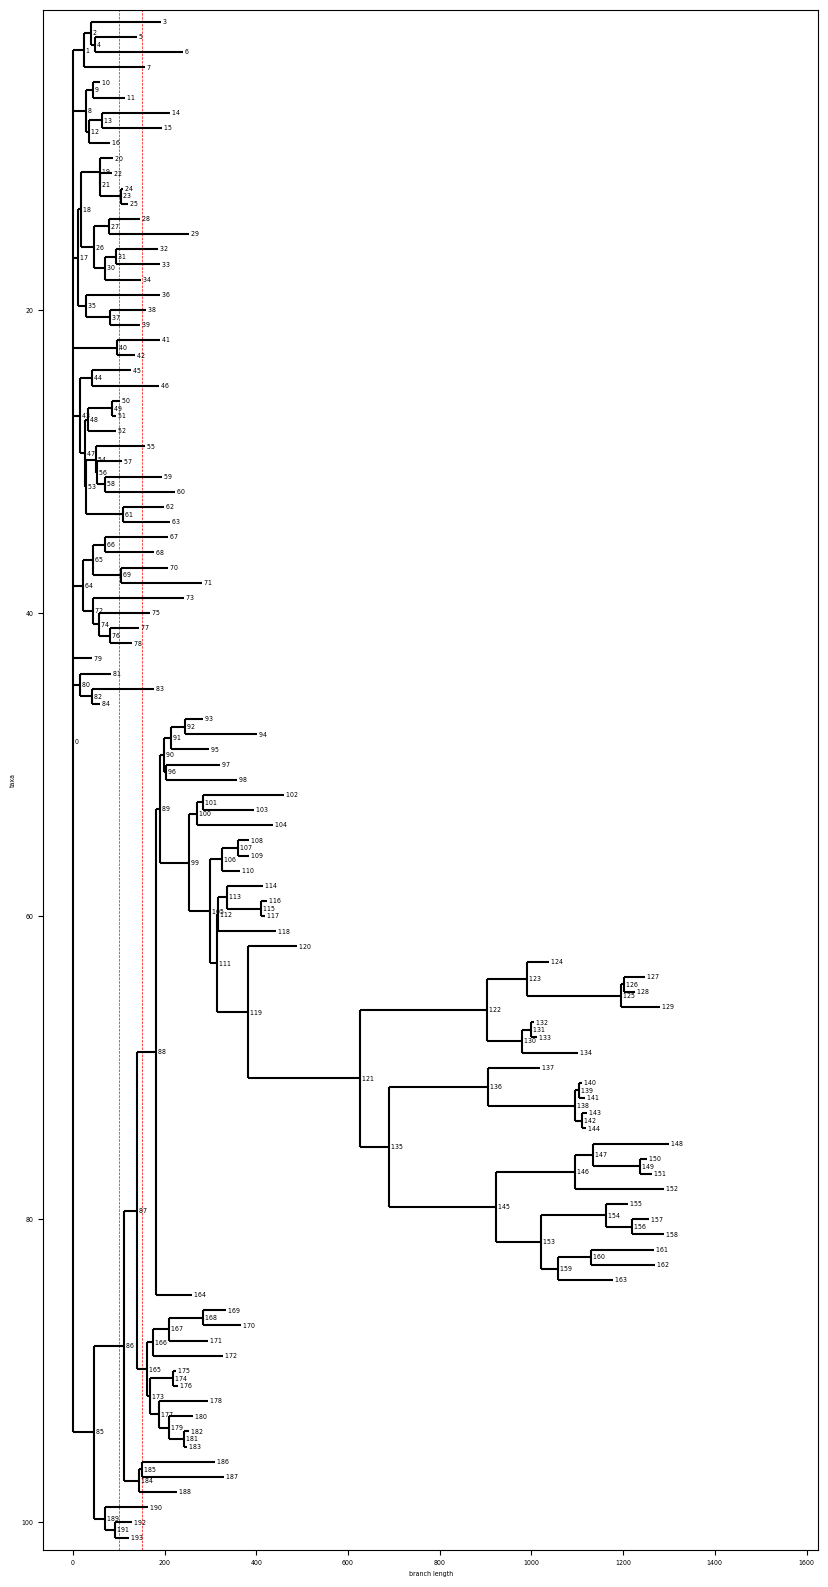

In [19]:
tree = Phylo.read("L5_morphology.xml", "phyloxml")
matplotlib.rc('font', size=4.5)
# set the size of the figure
fig = plt.figure(figsize=(10, 20), dpi=100)
# alternatively
# fig.set_size_inches(10, 20)
axes = fig.add_subplot(1, 1, 1)
axes.axvline(x=100, color="red", linestyle="--", linewidth=0.5)
axes.axvline(x=150, color="red", linestyle="--", linewidth=0.5)
Phylo.draw(tree, axes=axes)

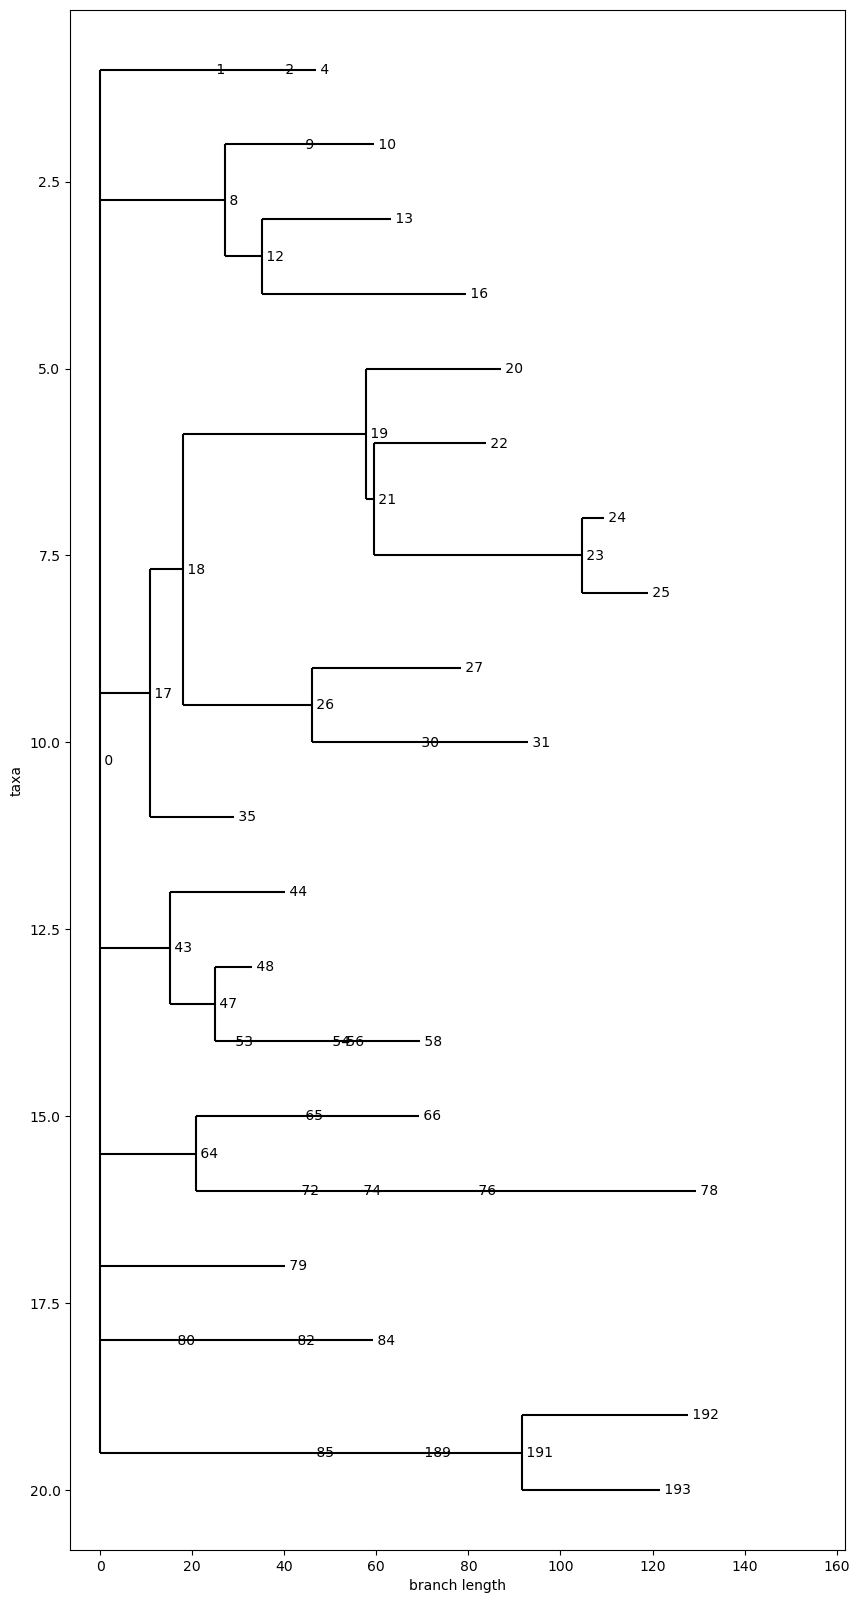

In [2]:
# 读取树结构
tree = Phylo.read("L5_morphology.xml", "phyloxml")

# 筛选分支函数
def prune_large_branches(clade, max_length):
    # 只保留 branch length 小于 max_length 的子节点
    clade.clades = [child for child in clade.clades if child.branch_length is None or child.branch_length < max_length]
    # 递归处理每个子节点
    for child in clade.clades:
        prune_large_branches(child, max_length)

# 筛选出 branch length 小于 150 的部分
max_branch_length = 50
prune_large_branches(tree.root, max_branch_length)

# 绘制筛选后的树
fig = plt.figure(figsize=(10, 20), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

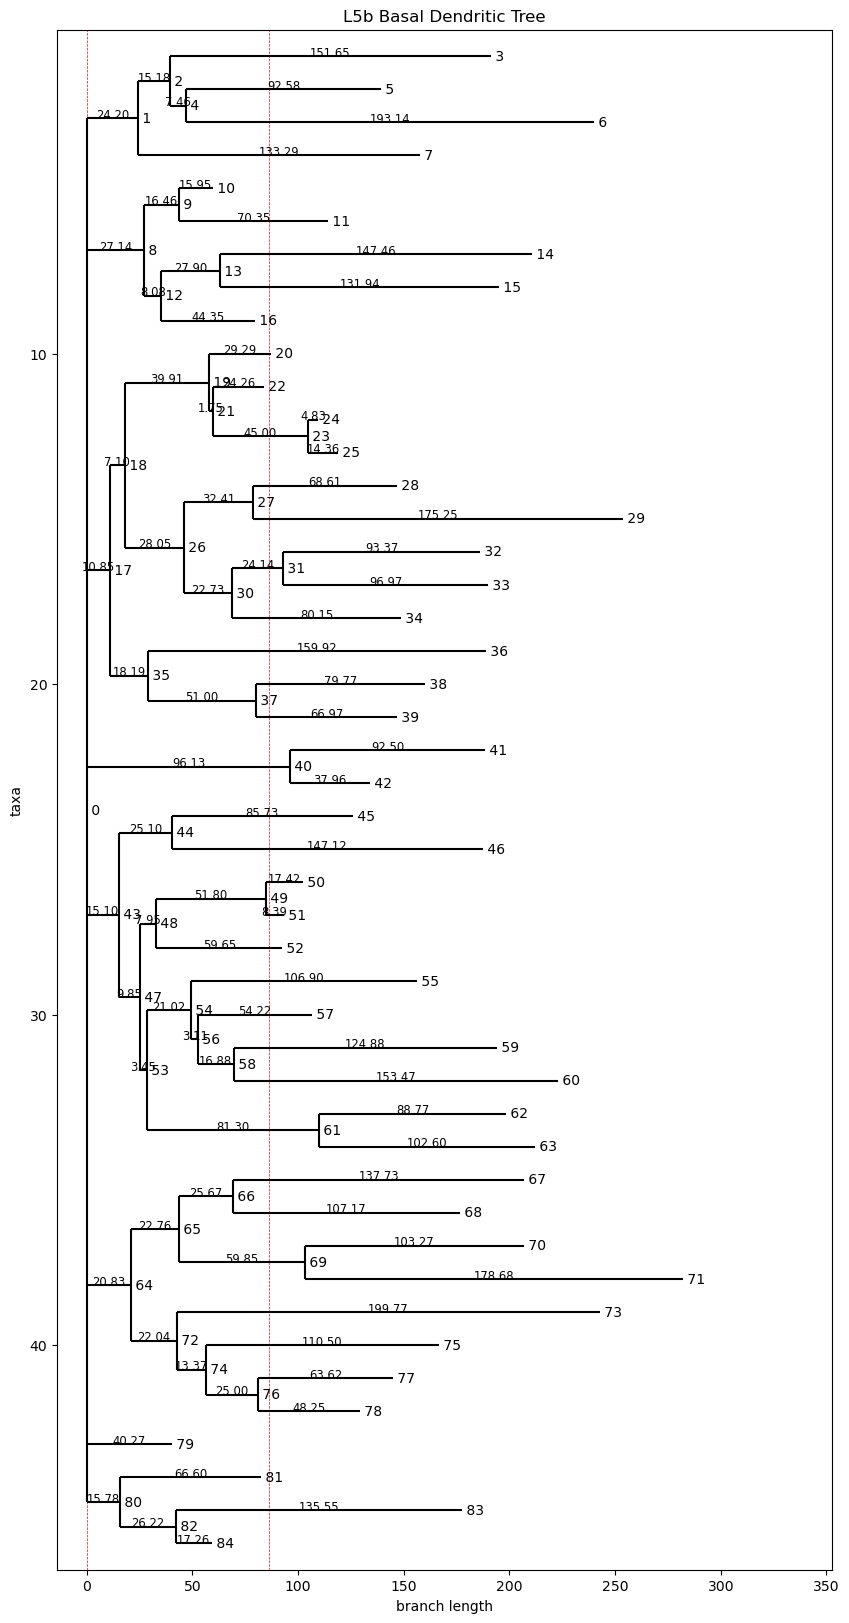

In [27]:
# 读取树结构
tree = Phylo.read("L5_morphology.xml", "phyloxml")

# 获取所有分支的编号
branch_list = []  # 保存 (编号, 分支对象)
assign_branch_numbers(tree.root, branch_list)

# 保留 0 到 84 编号的分支
branches_to_keep = {clade for num, clade in branch_list if num in range(85)}
prune_tree(tree.root)

# 绘制筛选后的树
matplotlib.rc('font', size=10)
fig = plt.figure(figsize=(10, 20), dpi=100)
axes = fig.add_subplot(1, 1, 1)
axes.axvline(x=0, color="red", linestyle="--", linewidth=0.5)
axes.axvline(x=86, color="red", linestyle="--", linewidth=0.5)
plt.title("L5b Basal Dendritic Tree")

# Phylo.draw(tree, axes=axes)
Phylo.draw(tree, branch_labels=lambda c: f"{c.branch_length:.2f}" if c.branch_length is not None else "", axes=axes)

## Morpho

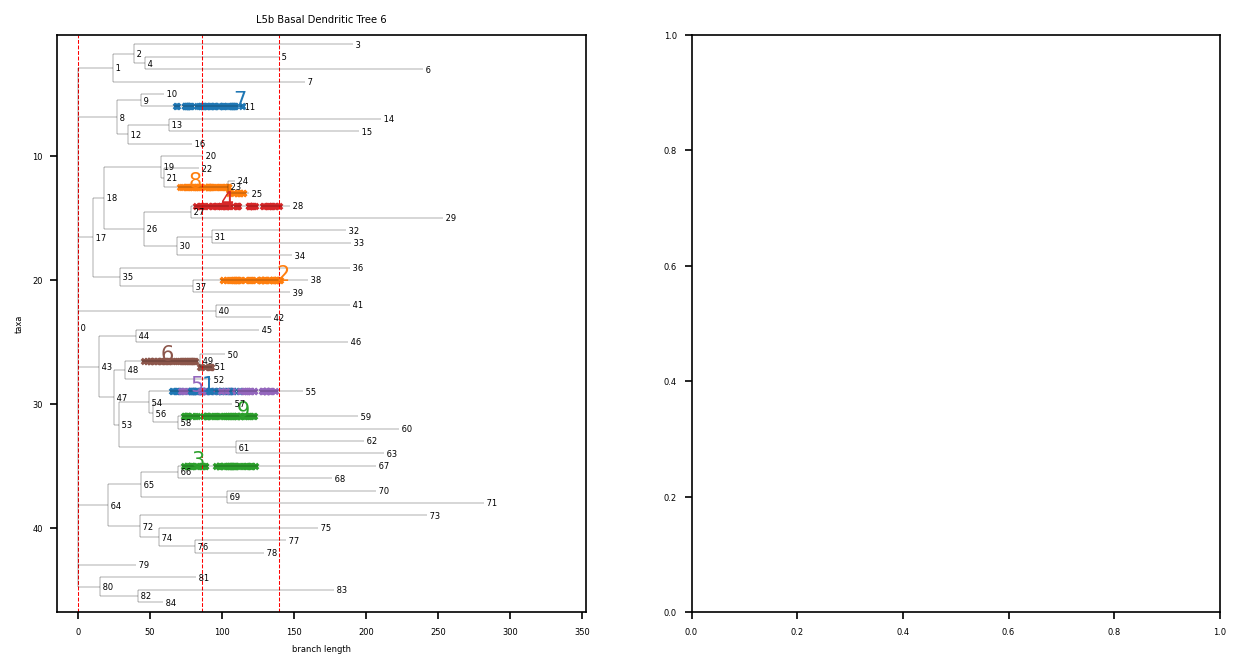

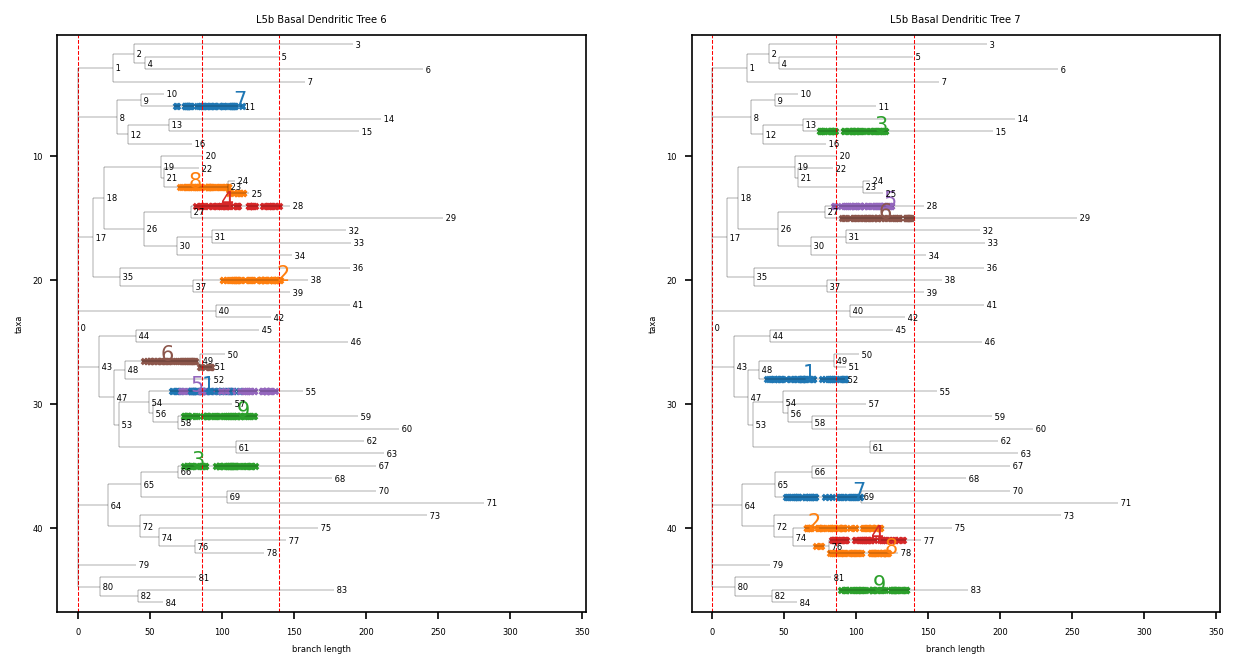

In [15]:
matplotlib.rc('font', size=4)

# 计算 y 坐标
def assign_y_coordinates(clade, y_coords, counter=[0]):
    """
    递归计算每个 clade（branch）的 y 坐标。
    - 叶子节点分配整数坐标
    - 内部节点取子节点 y 坐标的均值
    """
    if clade.is_terminal():  # 叶子节点
        y_coords[clade] = counter[0] + 1 # It actually starts from 1 
        counter[0] += 1
    else:  # 内部节点
        for child in clade.clades:
            assign_y_coordinates(child, y_coords, counter)
        y_coords[clade] = sum(y_coords[child] for child in clade.clades) / len(clade.clades)

tree = Phylo.read("L5_morphology.xml", "phyloxml")
# 获取所有分支的编号
branch_list = []  # 保存 (编号, 分支对象)
assign_branch_numbers(tree.root, branch_list)

# 保留 0 到 84 编号的分支
branches_to_keep = {clade for num, clade in branch_list if num in range(85)} #85
prune_tree(tree.root)

# 获取所有节点的坐标
depths = tree.depths()  # 获取所有分支的 x 坐标
leaf_nodes = tree.get_terminals()  # 获取叶子节点
y_coords = {leaf: i for i, leaf in enumerate(leaf_nodes)}  # y 坐标索引

# 存储 branch 对应的 y 坐标
y_coords = {}
assign_y_coordinates(tree.root, y_coords)
branch_y_list = [(clade, y) for clade, y in y_coords.items()]
branch_y_list.sort(key=lambda x: int(x[0].name)) # x[0]: clade (Bio.Phylo.PhyloXML.Clade), x[1]: y (int)

# # 输出结果
# for clade, y in branch_y_list:
    # print(f"Branch {clade.name}: y = {y}")

root_folder_path = '/G/results/simulation/'
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
test_folder_path_list = ['basal_range1_clus_invitro_variedW_tau90_shifted_addNaK/11/']

for test_folder_path in test_folder_path_list:
    # fig = plt.figure(figsize=(5, 5), dpi=150)
        # axes = fig.add_subplot(1, 1, 1)
    folder_idx_list = [6, 7]
    fig, axes = plt.subplots(1, len(folder_idx_list), figsize=(5*len(folder_idx_list), 5), dpi=150)
    for ax, folder_idx in zip(axes, folder_idx_list):
    
        ax.axvline(x=0, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(x=86, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(x=140, color="red", linestyle="--", linewidth=0.5)
        ax.set_title(f"L5b Basal Dendritic Tree {folder_idx}")

        section_synapse_df = pd.read_csv(root_folder_path + test_folder_path + f'{folder_idx}/section_synapse_df.csv')
        clus_section_df = section_synapse_df[(section_synapse_df['type'] == 'C')]

        txt_flag_list = [False] * 9
        for _, sec in clus_section_df.iterrows():
            section_id, loc, clus_id = sec['section_id_synapse'], sec['loc'], sec['cluster_id']
            branch = next((clade for num, clade in branch_list if num == section_id), None)
            if branch:
                x = depths.get(branch, 0)  # 获取分支的 x 轴坐标
                y = branch_y_list[section_id][1]  # 获取分支的 y 轴坐标
                branch_len = branch_y_list[section_id][0].branch_length
                # print(f"Branch {section_id}: x = {x}, y = {y}, branch_length = {branch_len}")
                ax.scatter(x-(1-loc)*branch_len, y, color=color_list[clus_id%6], marker="x", s=7)
                if not txt_flag_list[clus_id]:
                    ax.text(x-(1-loc)*branch_len, y, f'{clus_id+1}', fontsize=10, color=color_list[clus_id%6])
                    txt_flag_list[clus_id] = True
               
        for clade in tree.find_clades():
            clade.width = 0.1  # Adjust branch width globally
    
        plt.sca(ax) 
        Phylo.draw(tree, axes=ax)


## Other Morpho-irrelevant Code

In [20]:
import numpy as np
stim_time =500
num_stim=1

a= np.floor(np.random.normal(stim_time, 5, num_stim))
b = np.floor(np.array([stim_time]*num_stim))
print(a,b)

[492.] [500.]


In [8]:
folder_path = '/G/results/simulation/20241106_1657/1'
section_synapse_df = pd.read_csv(folder_path + '/section_synapse_df.csv')

# only read basal distance_to_soma
basal_distance = section_synapse_df[(section_synapse_df['region'] == 'basal') & (section_synapse_df['type'] == 'A')
                                     ]['distance_to_soma'].values
# read tuft distance not equal to 0
tuft_distance = section_synapse_df[(section_synapse_df['distance_to_tuft'] != -1) & (section_synapse_df['type'] == 'A')
                                    ]['distance_to_tuft'].values

print(len(section_synapse_df))
print(len(basal_distance), len(tuft_distance))
print(max(basal_distance), max(tuft_distance))

28922
9882 7692
293.694875610882 673.6713257143365


9466 7703
Basal: CDF crosses 3300 at distance 98.11452067192116
Basal: CDF crosses 6600 at distance 150.9242992369176
Tuft: CDF crosses 2500 at distance 345.09204001277914
Tuft: CDF crosses 5000 at distance 505.7075617632302
9466 7767
Basal: CDF crosses 3300 at distance 93.24935048098482
Basal: CDF crosses 6600 at distance 152.48282877213427
Tuft: CDF crosses 2500 at distance 342.9447685329689
Tuft: CDF crosses 5000 at distance 501.9686034766182
9466 7690
Basal: CDF crosses 3300 at distance 91.35183648056272
Basal: CDF crosses 6600 at distance 142.7328070719202
Tuft: CDF crosses 2500 at distance 340.9364809341544
Tuft: CDF crosses 5000 at distance 499.8320100795694


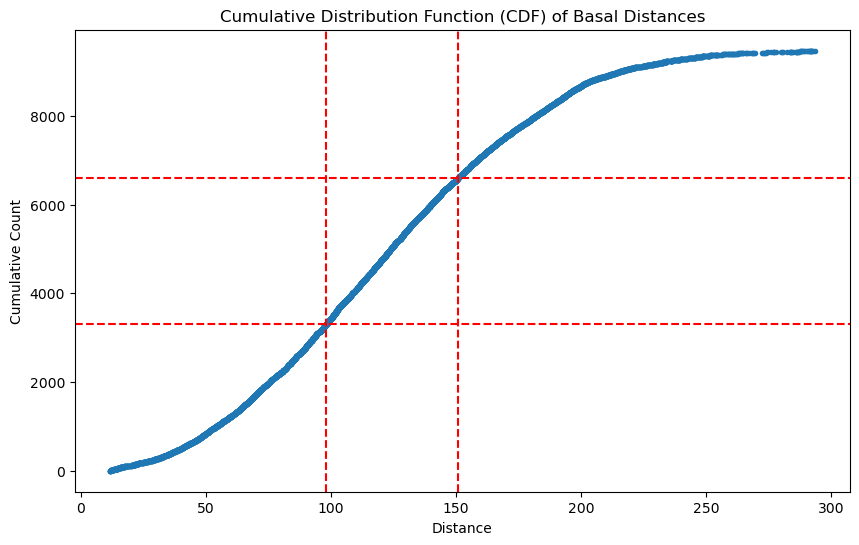

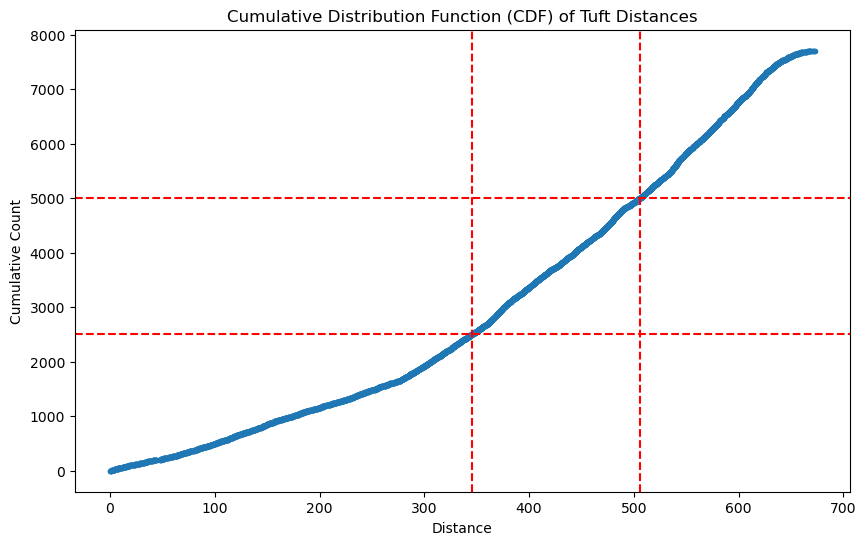

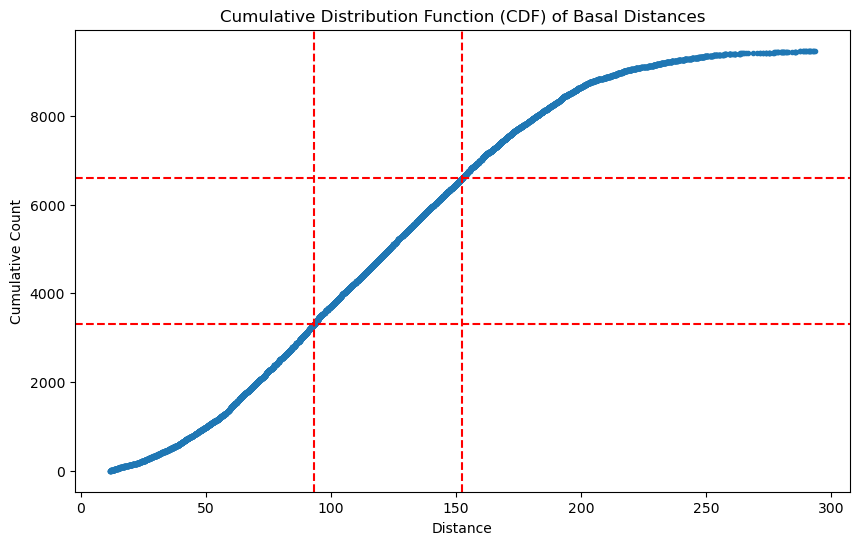

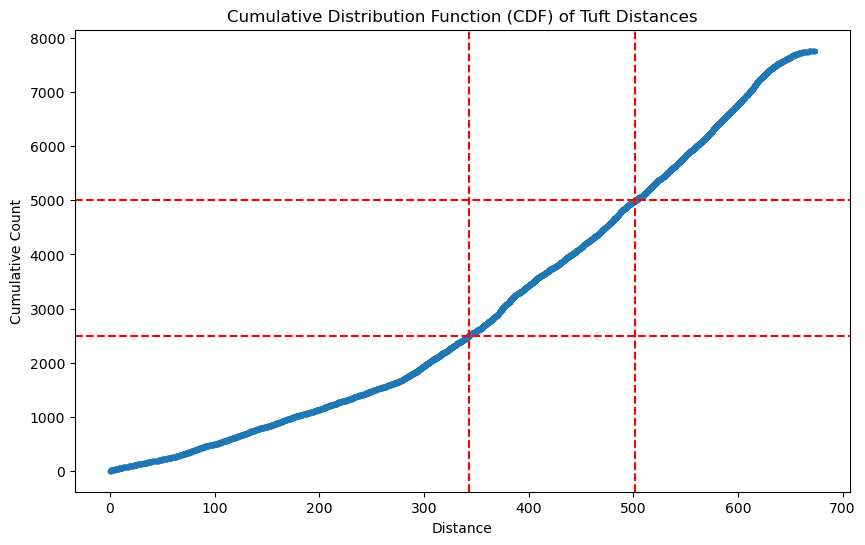

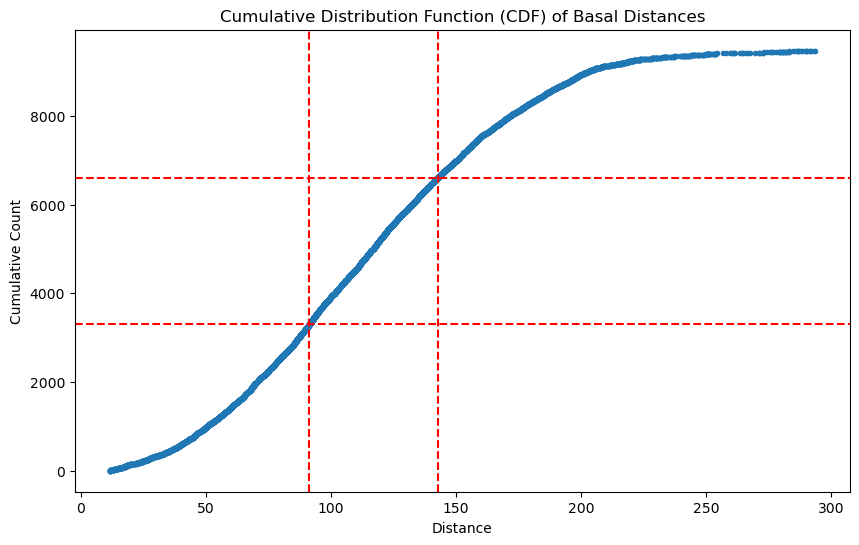

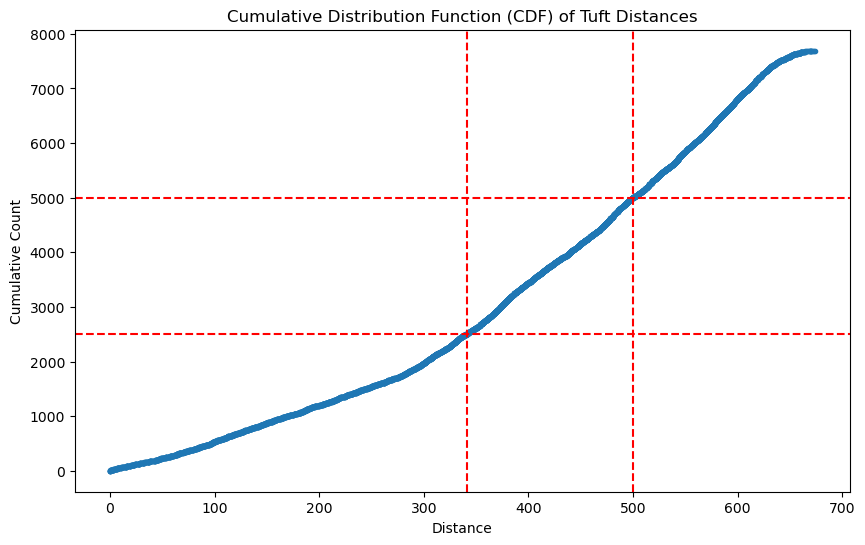

In [14]:
def visualize_dist_cdf(folder_path):
    section_synapse_df = pd.read_csv(folder_path + '/section_synapse_df.csv')

    # only read basal distance_to_soma
    basal_distance = section_synapse_df[(section_synapse_df['region'] == 'basal') & (section_synapse_df['type'] == 'A')
                                        ]['distance_to_soma'].values

    # read tuft distance not equal to 0
    tuft_distance = section_synapse_df[(section_synapse_df['distance_to_tuft'] != -1) & (section_synapse_df['type'] == 'A')
                                        ]['distance_to_tuft'].values

    print(len(basal_distance), len(tuft_distance))

    # Step 2: Sort the distances
    sorted_basal_distances = np.sort(basal_distance)
    sorted_tuft_distances = np.sort(tuft_distance)

    # Step 3: Calculate the cumulative count
    cumulative_count_basal = np.arange(1, len(sorted_basal_distances) + 1)
    cumulative_count_tuft = np.arange(1, len(sorted_tuft_distances) + 1)

    # Step 4: Plot the CDF with cumulative count
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_basal_distances, cumulative_count_basal, marker='.', linestyle='none')
    plt.xlabel('Distance')
    plt.ylabel('Cumulative Count')
    plt.title('Cumulative Distribution Function (CDF) of Basal Distances')

    # Draw red dashed lines at specified cumulative counts
    thresholds = [3300 + i * 3300 for i in range(2)]
    for threshold in thresholds:
        if threshold <= len(cumulative_count_basal):
            corresponding_distance = sorted_basal_distances[threshold - 1]
            plt.axhline(y=threshold, color='red', linestyle='--')
            plt.axvline(x=corresponding_distance, color='red', linestyle='--')
            print(f"Basal: CDF crosses {threshold} at distance {corresponding_distance}")

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_tuft_distances, cumulative_count_tuft, marker='.', linestyle='none')
    plt.xlabel('Distance')
    plt.ylabel('Cumulative Count')
    plt.title('Cumulative Distribution Function (CDF) of Tuft Distances')

    # Draw red dashed lines at specified cumulative counts
    thresholds  = [2500 + i * 2500 for i in range(2)]
    for threshold in thresholds:
        if threshold <= len(cumulative_count_tuft):
            corresponding_distance = sorted_tuft_distances[threshold - 1]
            plt.axhline(y=threshold, color='red', linestyle='--')
            plt.axvline(x=corresponding_distance, color='red', linestyle='--')
            print(f"Tuft: CDF crosses {threshold} at distance {corresponding_distance}")

# visualize_dist_cdf('/G/results/simulation/20241105_1035/1')
# visualize_dist_cdf('/G/results/simulation/20241105_1055/1')

visualize_dist_cdf('/G/results/simulation/basal_range0_clus_invitro_variedW_concentest_multi/32/1')
visualize_dist_cdf('/G/results/simulation/basal_range1_clus_invitro_variedW_concentest_multi/32/1')
visualize_dist_cdf('/G/results/simulation/basal_range2_clus_invitro_variedW_concentest_multi/32/14')
# visualize_dist_cdf('/G/results/simulation/basal_range0_clus_invitro/39/1')
# visualize_dist_cdf('/G/results/simulation/basal_range0_clus_invitro/40/1')

In [20]:
from concurrent.futures import ProcessPoolExecutor
import time

def dummy_task(worker_id):
    time.sleep(1)  # Simulate some work
    return worker_id

if __name__ == "__main__":
    max_workers = 4200  # Test with more workers than your CPU count
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(dummy_task, range(max_workers)))
    print("Test completed successfully!")


KeyboardInterrupt: 

In [55]:
# Example variables
num_syn_per_clus = 5
num_clusters = 24
num_conn_per_preunit = 3
num_preunit = num_syn_per_clus * np.ceil(num_clusters / num_conn_per_preunit).astype(int)

# Initialize results and connection counters
results = []
indices = []
connections_per_cluster = [0] * num_clusters

# Round-robin approach to evenly distribute connections without replacement
for _ in range(num_preunit):
    sampled = []
    available_clusters = list(range(num_clusters))
    for _ in range(num_conn_per_preunit):
        # Find the cluster with the minimum number of connections
        min_connections = min(connections_per_cluster)
        min_clusters = [i for i in available_clusters if connections_per_cluster[i] == min_connections]
        
        # Randomly choose one of the clusters with the minimum number of connections
        chosen_cluster = np.random.choice(min_clusters)
        
        # Add the chosen cluster to the sampled list and update the connection counter
        sampled.append(chosen_cluster)
        connections_per_cluster[chosen_cluster] += 1
        
        # Remove the chosen cluster from the available clusters
        available_clusters.remove(chosen_cluster)
    
    results.append(sampled)

# for _ in range(num_preunit):
#     sampled = []
#     for _ in range(num_conn_per_preunit):
#         # Find the cluster with the minimum number of connections
#         min_connections = min(connections_per_cluster)
#         min_clusters = [i for i, count in enumerate(connections_per_cluster) if count == min_connections]
        
#         # Randomly choose one of the clusters with the minimum number of connections
#         chosen_cluster = np.random.choice(min_clusters)
        
#         # Add the chosen cluster to the sampled list and update the connection counter
#         sampled.append(chosen_cluster)
#         connections_per_cluster[chosen_cluster] += 1
    
#     results.append(sampled)

for i in range(num_clusters):
    index_list = [j for j, lst in enumerate(results) for element in lst if element == i]
    indices.append(index_list)

print(results)
print(connections_per_cluster)
print(indices)

[[5, 18, 13], [19, 22, 2], [6, 17, 11], [14, 1, 7], [3, 12, 16], [9, 20, 4], [21, 8, 10], [0, 23, 15], [7, 3, 10], [21, 5, 15], [12, 17, 8], [18, 0, 16], [6, 11, 9], [19, 22, 13], [14, 4, 1], [23, 2, 20], [1, 18, 13], [5, 0, 11], [23, 8, 19], [12, 7, 4], [17, 21, 14], [6, 10, 9], [16, 2, 20], [3, 15, 22], [14, 12, 8], [6, 18, 17], [9, 23, 10], [2, 21, 19], [0, 4, 22], [13, 15, 3], [1, 7, 16], [11, 5, 20], [9, 5, 4], [6, 2, 22], [3, 17, 13], [14, 10, 16], [1, 8, 12], [15, 0, 21], [7, 18, 19], [11, 20, 23]]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[[7, 11, 17, 28, 37], [3, 14, 16, 30, 36], [1, 15, 22, 27, 33], [4, 8, 23, 29, 34], [5, 14, 19, 28, 32], [0, 9, 17, 31, 32], [2, 12, 21, 25, 33], [3, 8, 19, 30, 38], [6, 10, 18, 24, 36], [5, 12, 21, 26, 32], [6, 8, 21, 26, 35], [2, 12, 17, 31, 39], [4, 10, 19, 24, 36], [0, 13, 16, 29, 34], [3, 14, 20, 24, 35], [7, 9, 23, 29, 37], [4, 11, 22, 30, 35], [2, 10, 20, 25, 34], [0, 11, 16, 25, 38], [1, 13, 18, 27, 38], 

In [69]:
from scipy.stats import binom

# # parameters
# n_list = [10, 50, 100, 1000]  # sampling times
# k = 1  # number of times to sample A
# # k_list = [2, 10, 20, 200]  # number of times to sample A
# p = 0.1  # probability of sampling A

# for n in n_list:
#     prob = 1 - binom.pmf(0, n, p)
#     print(f"Probability of sampling A {k} times out of {n} samples: {prob:.4f}")

# Example section IDs
section_ids_A = [1, 6, 7]
section_ids_B = [1, 2, 3, 4, 5]

# Check if all section IDs in A are in B
all_in_B = not any(section_id in section_ids_B for section_id in section_ids_A)

print(all_in_B)  # Output: True

False


In [75]:
stack_flag = True
exp_idx = 1

if (not stack_flag) or (stack_flag and exp_idx == 0):
    print('Draw')
else:
    print('Skip')
    

Skip


In [134]:
from utils.generate_pink_noise import make_noise

FREQ_EXC = 10
DURATION = 1000

num_func_group = 10 # (26,000/5)/100 = 52
pink_noise_array = make_noise(num_traces=num_func_group, num_samples=DURATION)

pink_noise = pink_noise_array[np.random.randint(num_func_group)]
pink_noise[pink_noise<0] = 0
pink_noise = pink_noise/np.mean(pink_noise)

num_spks = 0
num_spks_masked = 0
num_epochs = 1
for i in range(num_epochs):
    counts = np.random.poisson(FREQ_EXC/1000 * pink_noise)
    spike_train = np.where(counts >= 1)[0] 
    num_spks += len(spike_train)
    # print(spike_train)

    mask = np.random.choice([True, False], size=spike_train.shape, p=[0.5, 0.5])
    spike_train = spike_train[mask]
    num_spks_masked += len(spike_train)
    # print(spike_train)
    
print(num_spks/num_epochs)
print(num_spks_masked/num_epochs)

[ 10  38 245 274 357 433 567 745 791 817 846 957]
[ 10 245 274 433 817 957]
12.0
6.0


0.39577480968784484
1.0
0.29078346922160087
1.0


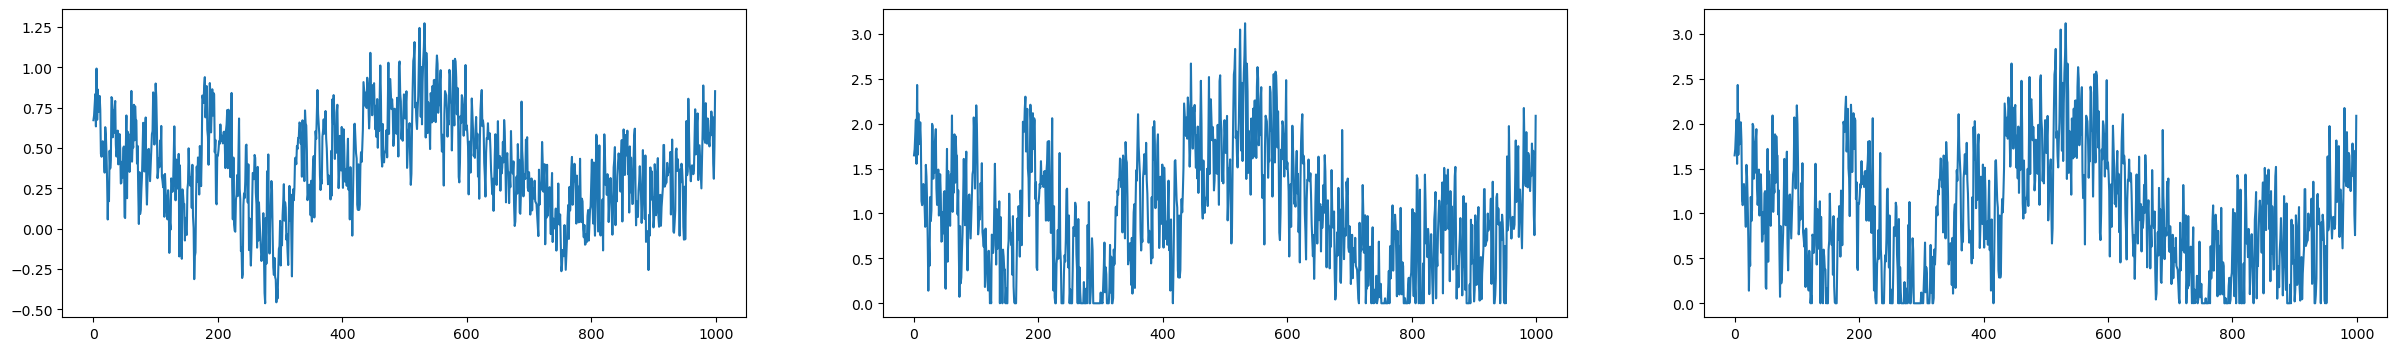

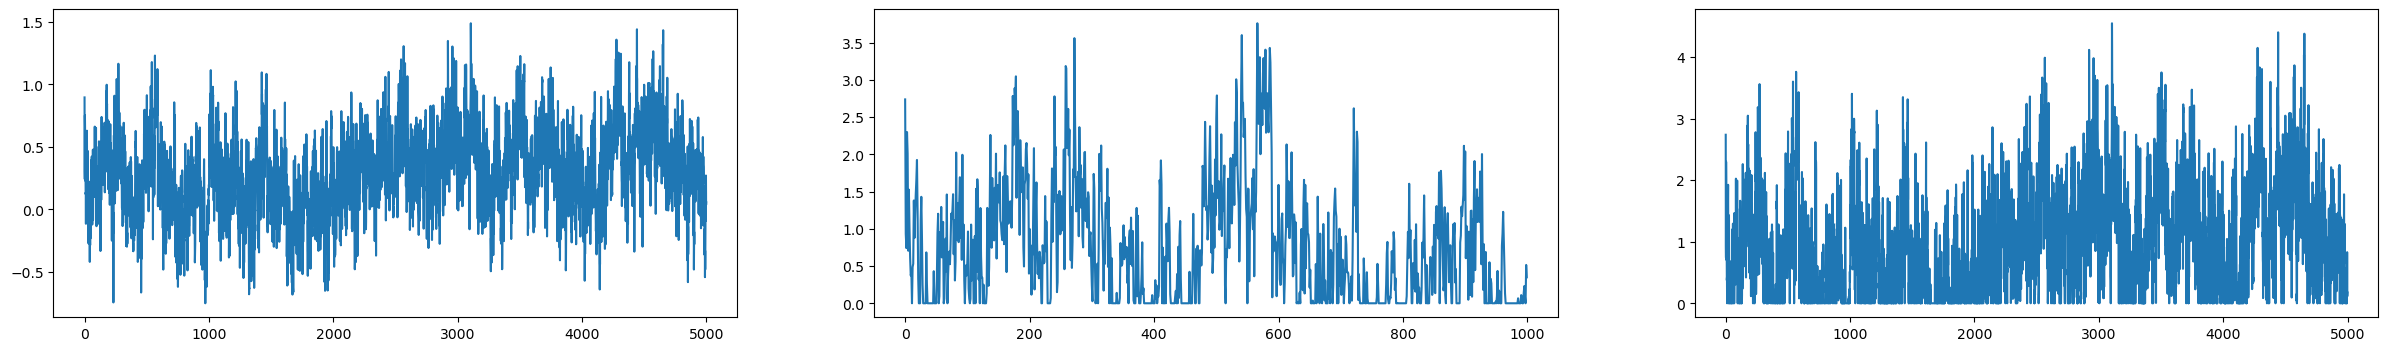

In [32]:
import numpy as np
from scipy import signal as ss
from scipy.stats import zscore
import matplotlib.pyplot as plt

def make_noise(num_traces=10, num_samples=1000):
    num_samples = num_samples+2000
    # Normalised Frequencies
    # fv = np.linspace(0, 1, 40)
    # Amplitudes Of '1/f'                                
    # a = 1/(1+2*fv)                
    # Filter Numerator Coefficients              
    # b = ss.firls(43, fv, a)                                   

    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    A = [1, -2.494956002,   2.017265875,  -0.522189400]

    invfn = np.zeros((num_traces,num_samples))

    for i in np.arange(0, num_traces):
        # Create White Noise
        wn = np.random.normal(loc=1, scale=0.5, size=num_samples) 
        # Create '1/f' Noise
        invfn[i,:] = zscore(ss.lfilter(B, A, wn))                           

    return invfn[:,2000:]

num_traces = 10
for num_samples in [1000, 5000]:
    sample_list = make_noise(num_traces=num_traces, num_samples=num_samples)

    sample = sample_list[2]
    print(np.mean(sample))
    plt.figure(figsize=(30, 4))
    plt.subplot(1, 3, 1)
    plt.plot(sample)

    sample[sample<0] = 0
    sample = sample/np.mean(sample)
    print(np.mean(sample))
    plt.subplot(1, 3, 2)
    plt.plot(sample[:1000])

    plt.subplot(1, 3, 3)
    plt.plot(sample)

In [34]:
import ast

# Example string
string_list = "[1, 2, 3, 4, 5]"

# Convert the string to a list
converted_list = ast.literal_eval(string_list)

print(converted_list)  # Output: [1, 2, 3, 4, 5]
print(type(converted_list))  # Output: <class 'list'>


[1, 2, 3, 4, 5]
<class 'list'>


In [65]:
# print(np.mean(np.random.poisson(2,1000)))

num_spk = 0
num_neurons = 200
for _ in range(num_neurons):
    num_spk += np.sum(np.random.poisson(2/1000,1000))
print(num_spk/num_neurons)

1.9
